# Data Mining / Prospecção de Dados

## Miguel Casanova, Nº 24475; Pedro Sá, Nº55046, 2019/20

# Project 1 - Pattern Mining

## Logistics

**In a "normal" scenario students should work in teams of 2 people. Due to the social distance imposed by current public health situation, students were allowed to work in groups of 1 and 3. In this context, the amount of work was adapted according to the number of students in groups as described below.**

* Task **1.** should be done by **all** groups
* Task **2.1.** should be done by **all** groups
* Task **2.2.** should be done only by **groups of 2 and 3** students
* Task **2.3** should be done only by **groups of 2 and 3** students
* Task **2.4** should be done only by **groups of 3** students
* Task **2.5** should be done only by **groups of 3** students

The quality of the project will then dictate its grade.

**The project's solution should be uploaded in Moodle before the end of April, 26th 2020 (23:59).** 

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. Note that you can use `PD_201920_Project.ipynb`as template.**

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 

**Decisions should be justified and results should be critically discussed.**

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[MLxtend](http://rasbt.github.io/mlxtend/)**. When using MLxtend, frequent patterns can either be discovered using `Apriori` and `FP-Growth`. **Choose the pattern mining algorithm to be used.** 

The dataset to be analysed is **`Foodmart_2020_PD.csv`**, a modified version of the [Foodmart 2000(2005) dataset](https://github.com/neo4j-examples/neo4j-foodmart-dataset/tree/master/data). 

**`Foodmart_2020_PD.csv`** stores **69549 transactions** from **24 stores**, where **103 different products** can be bought. Each transaction (row) has a STORE_ID (integer from 1 to 24), and a list of produts (items), together with the quantities bought. In the transation highlighted below, a customer bought 1 unit of soup, 2 of cheese and 1 of wine at store 2.

<img src="Foodmart_2020_PD_Example.png" alt="Foodmart_2020_PD_Example" style="width: 1000px;"/>

**In what follows keep the following question in mind and be creative!**

1. What are the most popular products?
2. Which products are bought together?
3. Can you find associations highliting that when people buy a product/set of products also buy other product(s)?

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first part of the project you should load and preprocessed the dataset **`Foodmart_2020_PD.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

### 1.1. Load and Preprocess Dataset

**We first load the transaction file, by using the 'load_transactions' function defined in previous TP classes. In order to ignore stores and product quantities, we adapt the function to satisfy our needs.**
#### **It should be noted that the Foodmart_2020 dataset has several typos, namely transactions without STORE_ID, transactions in which the items are not separated by commas, transactions that have one comma at the end of the transaction. This made the reading very tricky to debug and to get to a perfect level.**
#### **Also, during the analysis of the dataset, we realized that a few items, like Fresh Fruits and Fresh Vegetables, have a very high support, that might lead to strong association rules that have no meaning. We could have removed these items from the dataset, but we choose to keep them and remove the rules including them, by filtering them out later in the analysis.**

In [66]:
import re
def load_transactions (csv_file):
    """ This function has been specifically tailored to read the Foodmart_2020_PD.csv dataset. 
        It reads the csv file and adds each transaction on the dataset to a transaction_matrix.
        It copes with several problems in the dataset entries, namely products not separated by commas.
        input: csv file with one transaction per line, where transactions may have different number of items.
        Output: matrix where each row is a vector or items (transaction)
        Authors: Miguel Casanova and Pedro Sá (Apr 2020)"""

    lines = open(csv_file, 'r').readlines()
    
    transactions_matrix = []
    
    for l in lines:
        l = l.rstrip('\n')
        # The Foodmart_2020_PD.csv dataset has quite a few problems that we have encountered, sometimes fortuitously, sometimes by looking at data.
        # Namely, in several transactions, there was no ',' separating certain items, which led to the fusion of these items (e.g. SoupFresh Vegetables).
        # In addition, certain transactions ended with a ',', which led to the creation of empty strings in the list of transactions. 
        # For the above reasons, we concocted several solutions to read the dataset perfectly.
        
        # We use Python's Regex syntax, to split each transaction at the border between a digit and non-digit character. 
        transaction = re.split('(?<=\d)(?=\D)', l)
        # We create a new transaction, where we will store the "cleaned and trimmed" elements of the transaction list.
        processed_transaction = [transaction[0]]
        # We iterate on the transaction to process each element of the list.
        for element in transaction[1:]:
            # We remove '=' and ','.
            new_element = element.replace("=", "").replace(",","")
            # We remove all the digits from the elements of the list.
            new_element = ''.join([i for i in new_element if not i.isdigit()])
            # As explained above, certain transactions that end with a ',', will have an element that is empty (''). The following lines of code, will remove these elements.
            if new_element != '':
                processed_transaction.append(new_element)
        transactions_matrix.append(processed_transaction[1:])

    return transactions_matrix

In [67]:
# Load transaction from file Foodmart_2020_PD.csv and display first 10 transactions.
transactions = load_transactions('Foodmart_2020_PD.csv')
transactions[:10]

[['Pasta', 'Soup'],
 ['Soup', 'Fresh Vegetables', 'Milk', 'Plastic Utensils'],
 ['Cheese', 'Deodorizers', 'Hard Candy', 'Jam'],
 ['Fresh Vegetables'],
 ['Cleaners', 'Cookies', 'Eggs', 'Preserves'],
 ['Soup', 'Cheese', 'Nasal Sprays'],
 ['Dips', 'Jelly', 'Tofu'],
 ['Cookies', 'Preserves', 'Dips'],
 ['Fresh Vegetables', 'Cleaners', 'Cereal', 'Deli Meats', 'Rice'],
 ['Soup', 'Jelly', 'Flavored Drinks', 'French Fries', 'Spices']]

In [68]:
#Check the number of transactions in the transaction matrix that we just created.
print('This transaction matrix has', len(transactions), 'transactions (lines).')

This transaction matrix has 69549 transactions (lines).


#### MLxtend (Apriori and FP-Growth algorithms) receives a binary database. Thus, we need to transform the above transaction matrix, into a binary database.

In [69]:
import pandas as pd
from mlxtend.preprocessing import  TransactionEncoder

# Compute binary database (transactions X products )
tr_enc = TransactionEncoder()
trans_array = tr_enc.fit(transactions).transform(transactions)
binary_database = pd.DataFrame(trans_array, columns=tr_enc.columns_)
binary_database

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69544,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
69545,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
69546,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
69547,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [70]:
print('This binary database has', len(binary_database.columns), 'columns, corresponding to the number of distinct items found in the transaction list.')
print('This binary database has', len(binary_database), 'rows, corresponding to the number of transactions in the transaction list.')

This binary database has 102 columns, corresponding to the number of distinct items found in the transaction list.
This binary database has 69549 rows, corresponding to the number of transactions in the transaction list.


In [71]:
# Bellow, we can see the list of all items found in the transaction dataset.
list_items= []
for item in binary_database.columns:
    list_items.append(item)
print(list_items)
# With the pre-processing we used to read the csv file, we managed to get the right list of items in the dataset.

['Acetominifen', 'Anchovies', 'Aspirin', 'Auto Magazines', 'Bagels', 'Batteries', 'Beer', 'Bologna', 'Candles', 'Canned Fruit', 'Canned Vegetables', 'Cereal', 'Cheese', 'Chips', 'Chocolate', 'Chocolate Candy', 'Clams', 'Cleaners', 'Coffee', 'Cold Remedies', 'Computer Magazines', 'Conditioner', 'Cookies', 'Cooking Oil', 'Cottage Cheese', 'Crackers', 'Deli Meats', 'Deli Salads', 'Deodorizers', 'Dips', 'Donuts', 'Dried Fruit', 'Dried Meat', 'Eggs', 'Fashion Magazines', 'Flavored Drinks', 'French Fries', 'Fresh Chicken', 'Fresh Fish', 'Fresh Fruit', 'Fresh Vegetables', 'Frozen Chicken', 'Frozen Vegetables', 'Gum', 'Hamburger', 'Hard Candy', 'Home Magazines', 'Hot Dogs', 'Ibuprofen', 'Ice Cream', 'Jam', 'Jelly', 'Juice', 'Lightbulbs', 'Maps', 'Milk', 'Mouthwash', 'Muffins', 'Nasal Sprays', 'Nuts', 'Oysters', 'Pancake Mix', 'Pancakes', 'Paper Dishes', 'Paper Wipes', 'Pasta', 'Peanut Butter', 'Personal Hygiene', 'Pizza', 'Plastic Utensils', 'Popcorn', 'Popsicles', 'Pot Cleaners', 'Pot Scrubbe

### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support of X%. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.
* Change X and Y when it makes sense and discuss the results.

### We will start by calculating the efficiency of Apriori and FP-Growth for the dataset used here and plot these efficiencies for better visualizations of each other's performance.

#### Testing Apriori and FP-Growth efficiency with different values of minimum support.

In [57]:
from mlxtend.frequent_patterns import apriori
import time

aprioriTimesSupport = []

min_sup = [1.0, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]

#sample half the rows
for sup in min_sup:
    start = time.time()
    FI_apriori = apriori(binary_database, min_support=(sup))
    end = time.time()
    aprioriTimesSupport.append((end-start)*1000)
    
aprioriTimesSupport

[10.598182678222656,
 12.35818862915039,
 11.09933853149414,
 16.755342483520508,
 392.0011520385742,
 5607.690811157227,
 11627.408742904663,
 221815.78493118286]

In [58]:
from mlxtend.frequent_patterns import fpgrowth
import time

fpgrowthTimesSupport = []

min_sup = [1.0, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]

#sample half the rows
for sup in min_sup:
    start = time.time()
    FI_fpgrowth = fpgrowth(binary_database, min_support=(sup))
    end = time.time()
    fpgrowthTimesSupport.append((end-start)*1000)
    
fpgrowthTimesSupport

[452.12817192077637,
 483.457088470459,
 441.4033889770508,
 511.3673210144043,
 1521.7270851135254,
 1559.5414638519287,
 1488.4843826293945,
 2708.6241245269775]

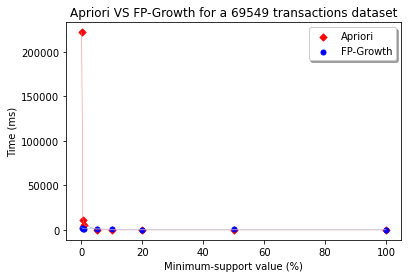

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

min_sup_labels = [100, 50, 20, 10, 5, 1, 0.5, 0.1]

plt.scatter(min_sup_labels, aprioriTimesSupport, marker="D", s=25, color="red", label="Apriori")
plt.plot(min_sup_labels, aprioriTimesSupport, color="lightcoral", linewidth=0.5)

plt.scatter(min_sup_labels, fpgrowthTimesSupport, marker="o", s=25, color="blue", label="FP-Growth")
plt.plot(min_sup_labels, fpgrowthTimesSupport, color="lightsteelblue", linewidth=0.5)

plt.xlabel("Minimum-support value (%)")
plt.ylabel("Time (ms)")

plt.title("Apriori VS FP-Growth for a 69549 transactions dataset")

#plt.yscale("log")

plt.legend(shadow=True)

plt.show()

#### Testing Apriori and FP-Growth efficiency with different sized datasets for minimum support value of 0.5%.

In [63]:
import time
aprioriTimesFraction = []

fractions = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

for frct in fractions:
    mini_db = binary_database.sample(frac=(frct), random_state=42)
    start = time.time()
    FI_apriori = apriori(binary_database, min_support=0.005)
    end = time.time()
    aprioriTimesFraction.append((end-start)*1000)
    
aprioriTimesFraction

[12317.479610443115,
 11181.293249130249,
 10728.306770324707,
 11114.693403244019,
 11000.787734985352,
 10763.685703277588,
 10692.308187484741,
 10857.719659805298,
 10974.38931465149,
 12401.973247528076]

In [64]:
import time
fpgrowthTimesFraction = []

fractions = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

for frct in fractions:
    mini_db = binary_database.sample(frac=(frct), random_state=42)
    start = time.time()
    FI_fpgrowth = fpgrowth(binary_database, min_support=0.005)
    end = time.time()
    fpgrowthTimesFraction.append((end-start)*1000)
    
fpgrowthTimesFraction

[1506.9928169250488,
 1527.1329879760742,
 1581.4721584320068,
 1466.1757946014404,
 1538.6786460876465,
 1441.6823387145996,
 1587.7838134765625,
 1597.3477363586426,
 1540.2863025665283,
 1602.6644706726074]

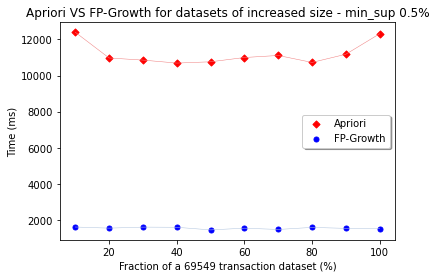

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

fractions_labels = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]

plt.scatter(fractions_labels, aprioriTimesFraction, marker="D", s=25, color="red", label="Apriori")
plt.plot(fractions_labels, aprioriTimesFraction, color="lightcoral", linewidth=0.5)

plt.scatter(fractions_labels, fpgrowthTimesFraction, marker="o", s=25, color="blue", label="FP-Growth")
plt.plot(fractions_labels, fpgrowthTimesFraction, color="lightsteelblue", linewidth=0.5)

plt.xlabel("Fraction of a 69549 transaction dataset (%)")
plt.ylabel("Time (ms)")

plt.title("Apriori VS FP-Growth for datasets of increased size - min_sup 0.5%")

#plt.yscale("log")

plt.legend(shadow=True)

plt.show()

**From the analysis of the above scatter plots, it is easy to see that, independently of the parameters, the FP-Growth algorith is the most performant method to determine frequent itemsets from the dataset used in this work. This is particularly critical when using values for minimum suport of 0.5% or below, in which case the Apriori algorithm becomes dramatically slow.**

**Furthermore, individual analysis of store types require the use of fractions of the available data. According to the previous scater plot, for minimum support values of 0.5%, it's also more efficient to use the FP-growth algorithm.**

**For the above reasons, we will restrict our further analysis to the use of FP-Growth.**

## Compute frequent itemsets considering a minimum support of X%.
- Our next step in the analysis, will try to get a better feeling about the dataset, namely in terms of values of minimum support to use.
- We will start by testing different values for minimum support, to find frequent itemsets but also to find a reasonably sized list of itemsets to use for rule estimation and allow efficient data mining of the data. 
- As mentioned above, we will use the FP-Growth algorithm to find frequent itemsets.
- We will run the fpgrowth algorithm once, with the lowest min_sup we have considered for this analysis, and filter from there, to calculate frequent itemsets with different values of minimum support.

In [72]:
from mlxtend.frequent_patterns import fpgrowth

# Compute itemsets min_support = 0.01%
frequent_itemsets_001 = fpgrowth(binary_database, min_support=0.0001, use_colnames=True)

# Add information about number of items in the itemset.
frequent_itemsets_001['length'] = frequent_itemsets_001['itemsets'].apply(lambda x: len(x))

# Add new column with number of occurences of the itemset in the dataset
frequent_itemsets_001['#transactions'] = frequent_itemsets_001['support'].apply(lambda x: x*69549)
frequent_itemsets_001 = frequent_itemsets_001.astype({'#transactions': 'int32'})

# Add new column with information about the percentage of transactions in which the itemset is present (more direct than looking at min_sup)
frequent_itemsets_001['%transactions'] = round(frequent_itemsets_001['support'].apply(lambda x: x*100), 3)

frequent_itemsets_001.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
99,0.012883,(Fresh Fish),1,896,1.288
95,0.012998,(Pancakes),1,903,1.300
83,0.013156,(Fashion Magazines),1,915,1.316
34,0.013271,(Sauces),1,923,1.327
100,0.013343,(Sardines),1,928,1.334
...,...,...,...,...,...
17548,0.000173,"(Fresh Fruit, Fresh Vegetables, Popcorn, Dried...",5,12,0.017
38520,0.000173,"(Fresh Fruit, Fresh Vegetables, Soup, Pizza, C...",5,12,0.017
28330,0.000187,"(Fresh Fruit, Fresh Vegetables, Soup, Nuts, Ch...",5,13,0.019
1011,0.000101,"(Plastic Utensils, Milk, Chocolate Candy, Bolo...",6,7,0.010


In [73]:
# Compute itemsets with min_supp = 0.1% (by filtering previous fpgrowth output)
frequent_itemsets_01 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.001]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_01.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
99,0.012883,(Fresh Fish),1,896,1.288
95,0.012998,(Pancakes),1,903,1.300
83,0.013156,(Fashion Magazines),1,915,1.316
34,0.013271,(Sauces),1,923,1.327
100,0.013343,(Sardines),1,928,1.334
...,...,...,...,...,...
14576,0.004687,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3,326,0.469
14548,0.004917,"(Fresh Vegetables, Dried Fruit, Fresh Fruit)",3,342,0.492
1676,0.005291,"(Fresh Vegetables, Cheese, Fresh Fruit)",3,368,0.529
3331,0.005521,"(Fresh Vegetables, Cookies, Fresh Fruit)",3,384,0.552


In [74]:
# Compute itemsets with min_supp = 0.5% (by filtering previous fpgrowth output)
frequent_itemsets_05 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.005]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_05.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
99,0.012883,(Fresh Fish),1,896,1.288
95,0.012998,(Pancakes),1,903,1.300
83,0.013156,(Fashion Magazines),1,915,1.316
34,0.013271,(Sauces),1,923,1.327
100,0.013343,(Sardines),1,928,1.334
...,...,...,...,...,...
102,0.035630,"(Fresh Vegetables, Soup)",2,2478,3.563
13752,0.050784,"(Fresh Vegetables, Fresh Fruit)",2,3532,5.078
1676,0.005291,"(Fresh Vegetables, Cheese, Fresh Fruit)",3,368,0.529
3331,0.005521,"(Fresh Vegetables, Cookies, Fresh Fruit)",3,384,0.552


In [75]:
# Compute itemsets with min_supp = 1% (by filtering previous fpgrowth output)
frequent_itemsets_1 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.01]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_1.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
99,0.012883,(Fresh Fish),1,896,1.288
95,0.012998,(Pancakes),1,903,1.300
83,0.013156,(Fashion Magazines),1,915,1.316
34,0.013271,(Sauces),1,923,1.327
100,0.013343,(Sardines),1,928,1.334
...,...,...,...,...,...
3326,0.027707,"(Fresh Vegetables, Cookies)",2,1927,2.771
1672,0.031129,"(Fresh Vegetables, Cheese)",2,2165,3.113
14537,0.035198,"(Fresh Vegetables, Dried Fruit)",2,2448,3.520
102,0.035630,"(Fresh Vegetables, Soup)",2,2478,3.563


In [76]:
# Compute itemsets with min_supp = 5% (by filtering previous fpgrowth output)
frequent_itemsets_5 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.05]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_5.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
39,0.052380,(Soda),1,3643,5.238
57,0.052783,(Popsicles),1,3671,5.278
44,0.052912,(Coffee),1,3680,5.291
18,0.053559,(Deli Meats),1,3725,5.356
41,0.053689,(Juice),1,3734,5.369
61,0.053948,(Batteries),1,3752,5.395
90,0.054048,(Pizza),1,3759,5.405
26,0.054206,(Cooking Oil),1,3770,5.421
17,0.054250,(Cereal),1,3773,5.425
36,0.054609,(Waffles),1,3798,5.461


In [77]:
# Compute itemsets with min_supp = 10% (by filtering previous fpgrowth output)
frequent_itemsets_10 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.1]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_10.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
9,0.105293,(Cookies),1,7323,10.529
32,0.117212,(Dried Fruit),1,8152,11.721
5,0.117672,(Cheese),1,8184,11.767
0,0.119743,(Soup),1,8328,11.974
29,0.175229,(Fresh Fruit),1,12187,17.523
2,0.283771,(Fresh Vegetables),1,19736,28.377


In [78]:
# Compute itemsets with min_supp = 20% (by filtering previous fpgrowth output)
frequent_itemsets_20 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.2]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_20.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
2,0.283771,(Fresh Vegetables),1,19736,28.377


### We next display a graphical representation of the dataset, namely of the number of itemsets for different values of minimum support.

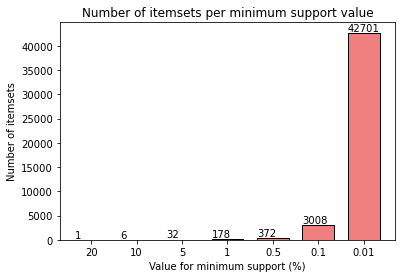

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt

minSup = ['20', '10', '5', '1', '0.5', '0.1', '0.01']
numberItems = [len(frequent_itemsets_20), len(frequent_itemsets_10), len(frequent_itemsets_5), len(frequent_itemsets_1), len(frequent_itemsets_05),
               len(frequent_itemsets_01), len(frequent_itemsets_001)]

#plt.bar(minSup, numberItems, align='center', alpha=0.5, color="lightcoral", edgecolor="black", linewidth=1.5)
bars = plt.bar(minSup, height=numberItems, align='center', color="lightcoral", edgecolor="black", linewidth=1, width=.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .05, yval, ha='left', va='bottom')
    
plt.ylabel('Number of itemsets')
plt.xlabel('Value for minimum support (%)')
plt.title('Number of itemsets per minimum support value')

plt.show()

- From the above analysis, we can have an idea about the characteristics of the dataset and how to start planning the extraction of relevant association rules from it. 
- We can observe that, due to the dimension of the dataset, high values of minimum support give a low number of frequent itemsets, which would make it useless to calculate association rules.
- Finally, from the histogram above, we can already start to see what support value we will use in order to find our association rules: association rules with a support lower than 0.1%.

## List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.

**An interesting and quick way of ascertaining the most sought after itemsets in a transaction list like this one, is to calculate the itemsets of a given lenght (with a determined number of items) with the highest support.**
- We will thus, calculate the top-10 list of frequent itemsets of sizes 1, 2 and 3.
- For this, we will start by running the fpgrowth algorithm with a low minimum support of 0.01%. This support allows us to obtain a set of itemsets that vary in size between 1 to 6 items. By varying the minimum support value, we will determine the support needed to obtain a top-10 itemsets of each size.

In [80]:
from mlxtend.frequent_patterns import fpgrowth

# Compute itemsets min_support = 0.01%
frequent_itemsets_001 = fpgrowth(binary_database, min_support=0.0001, use_colnames=True)

# Add information about number of items in the itemset.
frequent_itemsets_001['length'] = frequent_itemsets_001['itemsets'].apply(lambda x: len(x))

# Add new column with number of occurences of the itemset in the dataset
frequent_itemsets_001['#transactions'] = frequent_itemsets_001['support'].apply(lambda x: x*69549)
frequent_itemsets_001 = frequent_itemsets_001.astype({'#transactions': 'int32'})

# Add new column with information about the percentage of transactions in which the itemset is present (more direct than looking at min_sup)
frequent_itemsets_001['%transactions'] = round(frequent_itemsets_001['support'].apply(lambda x: x*100), 3)

### Top-10 of Frequent 1-itemsets

In [81]:
#Compute the top-10 subset of itemsets with a length of 1 items. Requires a minimum support of 6.8%.
frequent_itemsets_filter_1 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.068]
frequent_itemsets_filter_1 = frequent_itemsets_filter_1[(frequent_itemsets_filter_1['length'] == 1)]

frequent_itemsets_filter_1.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
43,0.068326,(Frozen Vegetables),1,4752,6.833
40,0.078520,(Canned Vegetables),1,5461,7.852
33,0.078937,(Paper Wipes),1,5490,7.894
72,0.080677,(Wine),1,5611,8.068
9,0.105293,(Cookies),1,7323,10.529
32,0.117212,(Dried Fruit),1,8152,11.721
5,0.117672,(Cheese),1,8184,11.767
0,0.119743,(Soup),1,8328,11.974
29,0.175229,(Fresh Fruit),1,12187,17.523
2,0.283771,(Fresh Vegetables),1,19736,28.377


### Top-10 of Frequent 2-itemsets

In [23]:
#Compute the top-10 subset of itemsets with a length of 2 items. Requires a minimum support of 2%.
frequent_itemsets_filter_2 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.02]
frequent_itemsets_filter_2 = frequent_itemsets_filter_2[(frequent_itemsets_filter_2['length'] == 2)]

frequent_itemsets_filter_2.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
1671,0.020403,"(Cheese, Fresh Fruit)",2,1419,2.040
30990,0.020475,"(Fresh Vegetables, Wine)",2,1424,2.047
103,0.020748,"(Soup, Fresh Fruit)",2,1443,2.075
16749,0.022056,"(Fresh Vegetables, Canned Vegetables)",2,1534,2.206
14552,0.022718,"(Paper Wipes, Fresh Vegetables)",2,1580,2.272
3326,0.027707,"(Fresh Vegetables, Cookies)",2,1927,2.771
1672,0.031129,"(Fresh Vegetables, Cheese)",2,2165,3.113
14537,0.035198,"(Fresh Vegetables, Dried Fruit)",2,2448,3.520
102,0.035630,"(Fresh Vegetables, Soup)",2,2478,3.563
13752,0.050784,"(Fresh Vegetables, Fresh Fruit)",2,3532,5.078


### Top-10 of Frequent 3-itemsets

In [24]:
#Compute the top-10 subset of itemsets with a length of 3 items. Requires a minimum support of 0.38%.
frequent_itemsets_filter_3 = frequent_itemsets_001[frequent_itemsets_001['support'] >= 0.0038]
frequent_itemsets_filter_3 = frequent_itemsets_filter_3[(frequent_itemsets_filter_3['length'] == 3)]

frequent_itemsets_filter_3.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
3341,0.003882,"(Fresh Vegetables, Soup, Cookies)",3,270,0.388
16757,0.004026,"(Fresh Vegetables, Canned Vegetables, Fresh Fr...",3,280,0.403
1674,0.004285,"(Fresh Vegetables, Soup, Cheese)",3,298,0.428
31019,0.004285,"(Fresh Vegetables, Wine, Fresh Fruit)",3,298,0.428
14549,0.004472,"(Fresh Vegetables, Cheese, Dried Fruit)",3,311,0.447
14576,0.004687,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3,326,0.469
14548,0.004917,"(Fresh Vegetables, Dried Fruit, Fresh Fruit)",3,342,0.492
1676,0.005291,"(Fresh Vegetables, Cheese, Fresh Fruit)",3,368,0.529
3331,0.005521,"(Fresh Vegetables, Cookies, Fresh Fruit)",3,384,0.552
104,0.007089,"(Fresh Vegetables, Soup, Fresh Fruit)",3,493,0.709


## Change X and Y when it makes sense and discuss the results.

- **From the above results, we can observe, as expected, that in order to get a significant number of itemsets from a dataset of this size, the minimum support has to be low.** 
- **Depending on our objectives, we will use different values for minimum support, to calculate frequent itemsets.**
- **For example, if we want to have items (or sets of items) that are bought often, we will use higher minimum support values. For example, a minimum support of 5% gives us 32 itemsets that are found in at least 3480 transactions in the dataset.**
- **On the other hand, to be able to efficiently calculate association rules, we will need to decrease minimum support, in order to have a high enough number of frequent itemsets. Here we can consider going as low as 0.01% minimum support.**

### 1.3. Generate Association Rules from Frequent Itemsets

* Generate association rules with a minimum confidence of C%. 
* Generate association rules with a minimum lift L. 
* Generate association rules with both confidence >= % and lift >= L.
* Change C and L when it makes sense and discuss the results.

## Generate association rules with a minimum confidence of C%.

**Finding a set of valuable and strong association rules, is not a trivial matter. The definition of various parameters to calculate these rules are rather subjective and, in the end, depends on the use the analyst wants to give to the rules it finds. In saying this, finding a set of association rules for this dataset has been a challenging exercise. If in, one hand, using higher support values gives us rules with higher support while compromising the confidence (and other comparative metrics of the rules), in another hand, using low support values gives us rules that happen very rarely in the transaction list, albeit with very high comparative metrics.**

**We have spent a long time trying different metrics and ended up deciding to take a risky approach to finding rules, but with a well defined business strategy in mind. We will try to calculate rules with a rather low support (0.01%, which corresponds to 7 transactions in total), but that have very high confidence, lift and conviction scores. Our aim is to choose rare buying patterns, but that always generate an association rule. With this knowledge in hand, we will devise promotional sales to increase the sale of the antecedent(s) of the rules, hoping to increase the sales of the consequent(s).**

With this little introduction to our approach, we continue with describing the metrics we are using:
- **Confidence** is an indication of how often the rule has been found to be true. The confidence value of a rule, X=>Y , with respect to a set of transactions T, is the proportion of the transactions that contains X which also contains Y.
- As mentioned above, given the size of the dataset, we envisage using low levels of minimum support to compute frequent itemsets. As such, we suggest using minimum support of 0.01%.
- Given the need to use low minimum support value, we will use very high confidence, in order to make sure the discovered rules are true most of the times. As such, we will use a **minimum threshold for confidence of 90%**.

In [84]:
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

#Compute itemsets with min_support = 0.01% 
frequent_itemsets_001 = fpgrowth(binary_database, min_support=0.0001, use_colnames=True)

# Generate association rules with confidence >= 90%
all_rules_confidence_09 = association_rules(frequent_itemsets_001, metric="confidence", min_threshold=1)

# As certain articles, like Fresh Fruits and Fresh Vegetables, have a very high number of transactions, 
# we want to eliminate the rules that have these items as consequents. For this, we use the following filtering:
# (note that we can eliminate this, just by increasing the lift value).
all_rules_confidence_09 = all_rules_confidence_09[(all_rules_confidence_09['consequent support'] < 0.17)]

# Sort the rules for confidence and lift values
all_rules_confidence_09.sort_values(by=['confidence', 'lift'])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
28,"(Pizza, Hot Dogs, Juice, Cheese)",(Soup),0.000101,0.119743,0.000101,1.0,8.351225,0.000089,inf
38,"(Sauces, Pizza, Hamburger)",(Soup),0.000101,0.119743,0.000101,1.0,8.351225,0.000089,inf
42,"(Pizza, Tuna, Pasta)",(Soup),0.000101,0.119743,0.000101,1.0,8.351225,0.000089,inf
87,"(Fresh Vegetables, Canned Vegetables, Fashion ...",(Soup),0.000101,0.119743,0.000101,1.0,8.351225,0.000089,inf
126,"(Cheese, Pizza, Preserves, Fresh Fruit)",(Soup),0.000101,0.119743,0.000101,1.0,8.351225,0.000089,inf
...,...,...,...,...,...,...,...,...,...
142,"(Cleaners, Hamburger, Jelly, Rice)",(Pot Scrubbers),0.000129,0.013415,0.000129,1.0,74.543408,0.000128,inf
158,"(Paper Wipes, Sliced Bread, Personal Hygiene, ...",(Fresh Fish),0.000101,0.012883,0.000101,1.0,77.621652,0.000099,inf
105,"(Screwdrivers, Popcorn, Fresh Vegetables, Drie...","(Nuts, Fresh Fruit)",0.000101,0.011877,0.000101,1.0,84.199758,0.000099,inf
69,"(Paper Wipes, Acetominifen, Nasal Sprays)","(Canned Vegetables, Chips)",0.000101,0.004371,0.000101,1.0,228.779605,0.000100,inf


## Generate association rules with a minimum lift L.

- The **Lift** of a rule is defined as the ratio of the observed support to that expected if X and Y were independent.
> - If the rule had a lift of 1, it would imply that the probability of occurrence of the antecedent and that of the consequent are independent of each other. When two events are independent of each other, no rule can be drawn involving those two events.
> - If the lift is > 1, that lets us know the degree to which those two occurrences are dependent on one another, and makes those rules potentially useful for predicting the consequent in future data sets.
> - If the lift is < 1, that lets us know the items are substitute to each other. This means that presence of one item has negative effect on presence of other item and vice versa.

- Certain itemsets in the dataset, have an extremely high support. This is the example of 'Fresh Fruits' and 'Fresh Vegetables', with supports of 17.5% and 28.4%, respectively. These items can, thus, create rules in which they are consequents to certain antecedents, just because they are found very often in the transactions dataset. The lift parameter, will consider the relative support of antecedent and consequent to estimate the probability of occurence of a rule.


In [26]:
# Generate association rules with lift >= 10
all_rules_lift_10 = association_rules(frequent_itemsets_001, metric="lift", min_threshold=10)
# Sort the rules for lift and confidence values
all_rules_lift_10.sort_values(by=['lift', 'confidence'])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3200,"(Canned Vegetables, Nuts, Aspirin)",(Soda),0.000302,0.052380,0.000158,0.523810,10.000118,0.000142,1.990001
3209,(Soda),"(Canned Vegetables, Nuts, Aspirin)",0.052380,0.000302,0.000158,0.003019,10.000118,0.000142,1.002726
1872,"(Paper Wipes, Shampoo)","(Deli Meats, Batteries)",0.003465,0.002904,0.000101,0.029046,10.000472,0.000091,1.026923
1875,"(Deli Meats, Batteries)","(Paper Wipes, Shampoo)",0.002904,0.003465,0.000101,0.034653,10.000472,0.000091,1.032308
2086,"(Mouthwash, Soup)","(Pizza, Cereal)",0.003652,0.003149,0.000115,0.031496,10.002373,0.000104,1.029269
...,...,...,...,...,...,...,...,...,...
4825,"(Paper Wipes, Sliced Bread, Personal Hygiene)","(Fresh Fish, Nasal Sprays)",0.000273,0.000417,0.000101,0.368421,883.562613,0.000101,1.582673
224,"(Milk, Soda, Chocolate Candy)","(Fresh Vegetables, Plastic Utensils, Bologna)",0.000244,0.000388,0.000101,0.411765,1060.660131,0.000101,1.699340
219,"(Fresh Vegetables, Plastic Utensils, Bologna)","(Milk, Soda, Chocolate Candy)",0.000388,0.000244,0.000101,0.259259,1060.660131,0.000101,1.349670
4605,"(Pot Scrubbers, Hamburger)","(Cleaners, Jelly, Rice)",0.000661,0.000173,0.000129,0.195652,1133.951087,0.000129,1.243029


## Generate association rules with both confidence >= % and lift >= L.

- With the aim of obtaining the strongest rules from our chosen parameters, we decided to find the association rules with a confidence of 100%, followed by filtering these rules to have all the rules with a lift higher than 35.
- This gives us ten rules, that albeit having happened only 7 times in the total transaction list, gives us a playground to test whether those buying patterns can be applied to a bigger number of transactions, by stimulating the sales of those products.

- In addition to the metrics that were used to select the association rules, we can also count on two more parameters to access the validity of the selected rules.
> - The **Leverage** measure corresponds to the value of the differences between the frequence of X and Y appearing together in the dataset and the expected frequency of X and Y if they where statistically dependent. Values of Leverage close to 0 indicates that the frequency of X and Y in our dataset is close to what would be expected if X and Y were dependent and, thus, points for a dependency relationship between the two sets of items. This is very useful when drawing marketing strategies.
> - Similar to leverage, the **Conviction** compares the expected frequency of X appearing without Y if they were statistically dependent with the frequency of X without Y in the dataset. Thus, rules with high conviction value corresponds to very interesting rules.

In [27]:
# Generate association rules with confidence = 100%
all_rules_confidence_1 = association_rules(frequent_itemsets_001, metric="confidence", min_threshold=1.0)

# Filter association rules using lift >= 35%
all_rules_confidence_1_lift = all_rules_confidence_1[all_rules_confidence_1['lift'] >= 35]

# Sort the rules for confidence and lift values
all_rules_confidence_1_lift.sort_values(by=['confidence', 'lift'])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
144,"(Cleaners, Pot Scrubbers, Jelly, Rice)",(Hamburger),0.000129,0.028297,0.000129,1.0,35.339939,0.000126,inf
67,"(Paper Wipes, Acetominifen, Canned Vegetables,...",(Nasal Sprays),0.000101,0.027721,0.000101,1.0,36.073133,0.000098,inf
6,"(Milk, Plastic Utensils, Soda, Bologna)","(Fresh Vegetables, Chocolate Candy)",0.000101,0.019109,0.000101,1.0,52.331828,0.000099,inf
106,"(Screwdrivers, Popcorn, Fresh Vegetables, Nuts)","(Dried Fruit, Fresh Fruit)",0.000101,0.018318,0.000101,1.0,54.591052,0.000099,inf
138,"(Hot Dogs, Cookies, Pancakes)","(Fresh Vegetables, Eggs)",0.000115,0.018016,0.000115,1.0,55.505986,0.000113,inf
142,"(Cleaners, Hamburger, Jelly, Rice)",(Pot Scrubbers),0.000129,0.013415,0.000129,1.0,74.543408,0.000128,inf
158,"(Paper Wipes, Sliced Bread, Personal Hygiene, ...",(Fresh Fish),0.000101,0.012883,0.000101,1.0,77.621652,0.000099,inf
105,"(Screwdrivers, Popcorn, Fresh Vegetables, Drie...","(Nuts, Fresh Fruit)",0.000101,0.011877,0.000101,1.0,84.199758,0.000099,inf
69,"(Paper Wipes, Acetominifen, Nasal Sprays)","(Canned Vegetables, Chips)",0.000101,0.004371,0.000101,1.0,228.779605,0.000100,inf
146,"(Pot Scrubbers, Hamburger, Jelly)","(Cleaners, Rice)",0.000129,0.001984,0.000129,1.0,503.978261,0.000129,inf


## Change C and L when it makes sense and discuss the results.

- As we can see above, we choose to use a low level of minimum support, for the determination of association rules. 
- The use of such a low minimum support is justified by the attempt to obtain association rules with a high level of confidence and a lift that ensures a given rule reflects a buying pattern.
- We are completely aware that the minimum support we choose is rather low (it corresponds to 7 transactions). We know that the rules we are picking might not translate well to an increase in the number of transactions (it is known that the lift metrics has a bias for rules with low support). Thus, our solution should take this into consideration and be aware of the shortcomings and potential problems with the rules we determine.
- In saying this, if we decide to accept rules with a lower confidence value, we could have increased the minimum support value. In our analysis, to get rules with a confidence of 0.5 (and rules that do not include the very common items like Fresh Fruits and Fresh Vegetables as consequents), we need to set a minimum support value of 0.02% (only 0.01% higher than the value we use). We decided that this slight increase in minimum support didn't justify this approach.
- The use of a reduced minimum support allows greater maneuvering using higher confidence and lift values to filter. Thus, the use of a confidence of 0.9 allows us to filter 200 association rules that present, in addition to high confidence values, extremely high lift values. This reflects a high confidence in the determined association rules, even if their frequency of occurrence is reduced.
- The association rules that were filtered using the lift present high values for this parameter. However, the confidence values obtained for these association rules are not very high, so a comulative strategy between the use of confidence levels greater than 0.9 and lift values greater than 10  give rise to stronger rules.

### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets

- An itemset is a unordered set of distinct items. The support of an itemset is the number of transactions that contain the itemset. 
- A frequent itemset is an itemset that appears in at least minsup transactions from the transaction database. 
- A frequent closed itemset is a frequent itemset that is not included in a proper superset having the same support. 
- A frequent maximal itemset is a frequent itemset that is not included in a proper superset that is a frequent itemset. The set of frequent maximal itemsets is thus a subset of the set of frequent closed itemsets, which is a subset of frequent itemsets. Why it is interesting to discover frequent maximal itemsets ? The reason is that the set of frequent maximal itemsets is usually much smaller than the set of frequent itemsets and also smaller than the set of frequent closed itemsets. However, unlike frequent closed itemsets, frequent maximal itemsets are not a lossless representation of the set of frequent itemsets (it is possible to regenerate all frequent itemsets from the set of frequent maximal itemsets but it would not be possible to get their support without scanning the database).
- In other words, a frequent maximal itemset is a frequent itemset (that has, at least, a pre-determined minimum support) that contains no superset (another itemset containing this itemset plus other items) that meets the minimum support criteria.
- We will use the fpmax algorith to compute maximal frequent itemsets.

In [28]:
from mlxtend.frequent_patterns import fpmax

#Compute Maximal Frequent itemsets with min_support = 0.5% 
fp_max = fpmax(binary_database, min_support=0.005, use_colnames=True)

# Add new column length
fp_max['length'] = fp_max['itemsets'].apply(lambda x: len(x))

# Add new column with number of occurences of the itemset in the dataset
fp_max['#transactions'] = fp_max['support'].apply(lambda x: x*69549)
fp_max = fp_max.astype({'#transactions': 'int32'})
#fp_max = fp_max[(fp_max['length'] == 2)]

# Add new column with information about the percentage of transactions in which the itemset is present (more direct than looking at min_sup)
fp_max['%transactions'] = round(fp_max['support'].apply(lambda x: x*100), 3)

#We will print the dataframe of the maximal frequent itemsets, organizing the rows by lenght first and then support.
fp_max.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
0,0.012883,(Fresh Fish),1,896,1.288
1,0.012998,(Pancakes),1,903,1.300
2,0.013156,(Fashion Magazines),1,915,1.316
3,0.013271,(Sauces),1,923,1.327
4,0.013343,(Sardines),1,928,1.334
...,...,...,...,...,...
56,0.028958,"(Fresh Vegetables, Cold Remedies)",2,2014,2.896
294,0.035198,"(Fresh Vegetables, Dried Fruit)",2,2448,3.520
290,0.018879,"(Fresh Vegetables, Cookies, Fresh Fruit)",3,1313,1.888
296,0.020403,"(Fresh Vegetables, Cheese, Fresh Fruit)",3,1419,2.040


- As we can see, whereas we get 372 frequent itemsets with minimum support of 0.5%, we only get a subset of this, if we determine the maximal frequent itemsets (298, in this case). 
- We won't use these itemsets for our analysis and comparison of the different stores.

### 1.5 Conclusions from Mining Frequent Patterns in All Stores

#### From the analysis of the whole FoodMart_2020_PD.csv dataset, we can make some conclusions:
- This dataset contains 69549 transactions (where we have listed 102 different items). 
- Given the dimension of the dataset, we are obliged to use low values of minimum support, to calculate association rules.
- The top-10 most frequent itemsets bought, gives us a good idea of the items that are most bought in all the stores. 
- The association rules we obtained, when analyzed in a logical point of view, actually make sense. Here are a few examples:
> - Buying (Cleaners, Rice), after buying (Jelly, Pot Scrubbers, Hamburger).
> - Buying (Nasal Sprays), when also buying (Paper Wipes, Chips, Acetominifen, Canned Vegetables).
> - Buying (Nuts, Fresh Fruit) , together with (Popcorn, Screwdrivers, Dried Fruit, Fresh Vegetables).
- All the above rules are logical and thus, gives us the feeling that they are good rules to try and explore to increase sales of those products. What we could do is to increase sales in packs, make promotions of particular items, change the location of antecedents and consequents (and, for example, put a consequent with a higher profit margin, closer to the antecedent products).

- A final point should be made, about the dataset and our effort to predict common behaviours from it. This dataset encompasses several types of different stores, aimed at different types of buyer's profiles. Thus, the rules we obtain will omit info pertaining to particular type of stores (and actually, mix them al together). This will be the focus of the next part of this project.

## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores, and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store. 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21) and Gourmet Supermarkets (STORE_ID = 4, 6) together**.

#### 2.1.1. Load/Preprocess the Dataset

In [29]:
import re
def load_transactions_store_type (csv_file):
    """ This function has been specifically tailored to read the Foodmart_2020_PD.csv dataset and take into account store information. 
        It reads the csv file and adds each transaction on the dataset to a transaction_matrix of the corresponding store type.
        It copes with several problems in the dataset entries, namely products not separated by commas.
        input: csv file with one transaction per line, where transactions may have different number of items.
        Output: several matrixes corresponding to different types of store types where each row is a vector or items (transaction)
        Authors: Miguel Casanova and Pedro Sá (Apr 2020)"""

    lines = open(csv_file, 'r').readlines()
    
    # We start by defining variables identifying the type of store, for every store.
    # It should be noted that there is the STORE_ID=24 that is not given a story type above.
    # In addition, there are transactions without STORE_ID.
    
    deluxe = ['STORE_ID=8', 'STORE_ID=12', 'STORE_ID=13', 'STORE_ID=17', 'STORE_ID=19', 'STORE_ID=21']
    gourmet = ['STORE_ID=4', 'STORE_ID=6']
    mid_size = ['STORE_ID=9', 'STORE_ID=18', 'STORE_ID=20', 'STORE_ID=23']
    small = ['STORE_ID=2', 'STORE_ID=5', 'STORE_ID=14', 'STORE_ID=22']
    supermarket = ['STORE_ID=1', 'STORE_ID=3', 'STORE_ID=7', 'STORE_ID=10', 'STORE_ID=11', 'STORE_ID=15', 'STORE_ID=16']
    
    # Even though the following code might not be essencial, it will streamline our code to allow us to get any kind of transaction matrix for all different types of stores.
    # For that reason, we create a different matrix for transactions associated with stores of the types defined above.
    
    deluxe_transactions_matrix = []
    gourmet_transactions_matrix = []
    mid_size_transactions_matrix = []
    small_transactions_matrix = []
    supermarket_transaction_matrix = []
    invalid_transaction_matrix = []
    
    #For the reasons explained in the initial section, we will need to implement certain strategies to compensate for the errors and typos found in the provided dataset.
    for l in lines:
        l = l.rstrip('\n')
        # The Foodmart_2020_PD.csv dataset has quite a few problems that we have encountered, sometimes fortuitously, sometimes by looking at data.
        # Namely, in several transactions, there was no ',' separating certain items, which led to the fusion of these items (e.g. SoupFresh Vegetables).
        # In addition, certain transactions ended with a ',', which led to the creation of empty strings in the list of transactions. 
        # For the above reasons, we concocted several solutions to read the dataset perfectly.
        
        # We use Python's Regex syntax, to split each transaction at the border between a digit and non-digit character. 
        transaction = re.split('(?<=\d)(?=\D)', l)
        # We create a new list for the transaction, initializing it with the 1st element of the list, containing the STORE_ID.
        processed_transaction = [transaction[0]]
        
        # We iterate on the transaction list (excluding the STORE_ID element) to process the data, removing '=', ',' and digits.
        # Each item on the transaction that has been processed, is appended to the processed_transaction list (except if the item is '', result of a problem with the dataset).
        for element in transaction[1:]:
            new_element = element.replace("=", "").replace(",","")
            new_element = ''.join([i for i in new_element if not i.isdigit()])
            if new_element != '':
                processed_transaction.append(new_element)
        
        # The new processed_transaction list, will be controlled for the presence of a STORE_ID belonging to the store types specified above 
        # and appended to the respective transaction matrix. 
        # For the sake of inclusiveness, also the transactions that do not have a STORE_ID will be added to an invalid transaction matrix.
        # Because we like to see the numbers fitting perfectly, we also add the transactions from STORE_ID=24 to the invalid transaction matrix.
        if processed_transaction[0] in deluxe:
            deluxe_transactions_matrix.append(processed_transaction[1:])
        if processed_transaction[0] in gourmet:
            gourmet_transactions_matrix.append(processed_transaction[1:])
        if processed_transaction[0] in mid_size:
            mid_size_transactions_matrix.append(processed_transaction[1:])
        if processed_transaction[0] in small:
            small_transactions_matrix.append(processed_transaction[1:])    
        if processed_transaction[0] in supermarket:
            supermarket_transaction_matrix.append(processed_transaction[1:])
        if processed_transaction[0][0:5] != 'STORE' or processed_transaction[0] == 'STORE_ID=24': 
            invalid_transaction_matrix.append(processed_transaction[:])
        
    return (deluxe_transactions_matrix, gourmet_transactions_matrix, mid_size_transactions_matrix, small_transactions_matrix, supermarket_transaction_matrix, invalid_transaction_matrix)

In [30]:
# Load transaction from file Foodmart_2020_PD.csv into distinct transaction matrixes.
dtm, gtm, mtm, stm, suptm, itm = load_transactions_store_type('Foodmart_2020_PD.csv')

In [31]:
#Check the number of transactions in the transaction matrix that we just created.
print('This transaction matrix has', len(dtm) + len(gtm) + len(mtm) + len(stm) + len(suptm) + len(itm), 'transactions (lines).')

This transaction matrix has 69549 transactions (lines).


#### **Including the 'invalid_transaction_matrix' (that contains STORE_ID=24 and transactions without STORE_ID), the total number of lines is similar to that of the whole dataset (69549).** 

- We will now fuse the Deluxe and Gourmet transaction matrixes to obtain a single binary database for these type of Supermarkets.

In [32]:
import pandas as pd
from mlxtend.preprocessing import  TransactionEncoder

# We start by joining the deluxe and gourmet transaction matrixes.
from copy import deepcopy
dgtm = deepcopy(dtm)
dgtm.extend(gtm)

# Compute binary database for deluxe and gourmet transaction matrixes (transactions X products )
tr_enc = TransactionEncoder()
trans_array = tr_enc.fit(dgtm).transform(dgtm)
binary_database_del_gour = pd.DataFrame(trans_array, columns=tr_enc.columns_)
binary_database_del_gour

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31246,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31247,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31248,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
31249,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [33]:
print('This binary database has', len(binary_database_del_gour.columns), 'columns, corresponding to the number of distinct items found in the transaction list.')
print('This binary database has', len(binary_database_del_gour), 'rows, corresponding to the number of transactions in the transaction list.')

This binary database has 102 columns, corresponding to the number of distinct items found in the transaction list.
This binary database has 31251 rows, corresponding to the number of transactions in the transaction list.


### The Gourmet and Deluxe transactions make up almost 45% of the original dataset. Given the size of this fraction of the original dataset, we can already guess that we won't be able to find major differences in buying patterns between the total dataset and this one. Let's see if that's the case!

#### 2.1.2. Compute Frequent Itemsets

### We will start by processing the dataset similarly to the way we processed the previous dataset. This will allow us to get a better idea about the data.

In [34]:
from mlxtend.frequent_patterns import fpgrowth

# Compute itemsets min_support = 0.01%
frequent_itemsets_DG_001 = fpgrowth(binary_database_del_gour, min_support=0.0001, use_colnames=True)

# Add information about number of items in the itemset.
frequent_itemsets_DG_001['length'] = frequent_itemsets_DG_001['itemsets'].apply(lambda x: len(x))

# Add new column with number of occurences of the itemset in the dataset
frequent_itemsets_DG_001['#transactions'] = frequent_itemsets_DG_001['support'].apply(lambda x: x*69549)
frequent_itemsets_DG_001 = frequent_itemsets_DG_001.astype({'#transactions': 'int32'})

# Add new column with information about the percentage of transactions in which the itemset is present (more direct than looking at min_sup)
frequent_itemsets_DG_001['%transactions'] = round(frequent_itemsets_DG_001['support'].apply(lambda x: x*100), 3)

frequent_itemsets_DG_001.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
80,0.012704,(Fresh Fish),1,883,1.270
67,0.012864,(Candles),1,894,1.286
100,0.012928,(Pots and Pans),1,899,1.293
92,0.012992,(Shrimp),1,903,1.299
50,0.013120,(Sauces),1,912,1.312
...,...,...,...,...,...
12819,0.000160,"(Fresh Fruit, Fresh Vegetables, Home Magazines...",6,11,0.016
22141,0.000160,"(Plastic Utensils, Milk, Chocolate Candy, Bolo...",6,11,0.016
25270,0.000128,"(Waffles, Fresh Fruit, Soup, Candles, Wine, Mo...",7,8,0.013
26042,0.000128,"(Deli Salads, Milk, Pizza, Fresh Vegetables, H...",7,8,0.013


In [35]:
# Compute itemsets with min_supp = 0.1% (by filtering previous fpgrowth output)
frequent_itemsets_DG_01 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.001]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_DG_01.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
80,0.012704,(Fresh Fish),1,883,1.270
67,0.012864,(Candles),1,894,1.286
100,0.012928,(Pots and Pans),1,899,1.293
92,0.012992,(Shrimp),1,903,1.299
50,0.013120,(Sauces),1,912,1.312
...,...,...,...,...,...
1445,0.005024,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3,349,0.502
14467,0.005344,"(Fresh Vegetables, Cheese, Fresh Fruit)",3,371,0.534
5229,0.006080,"(Fresh Vegetables, Cookies, Fresh Fruit)",3,422,0.608
105,0.008064,"(Fresh Vegetables, Soup, Fresh Fruit)",3,560,0.806


In [36]:
# Compute itemsets with min_supp = 0.1% (by filtering previous fpgrowth output)
frequent_itemsets_DG_05 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.005]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_DG_05.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
80,0.012704,(Fresh Fish),1,883,1.270
67,0.012864,(Candles),1,894,1.286
100,0.012928,(Pots and Pans),1,899,1.293
92,0.012992,(Shrimp),1,903,1.299
50,0.013120,(Sauces),1,912,1.312
...,...,...,...,...,...
102,0.051806,"(Fresh Vegetables, Fresh Fruit)",2,3603,5.181
1445,0.005024,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3,349,0.502
14467,0.005344,"(Fresh Vegetables, Cheese, Fresh Fruit)",3,371,0.534
5229,0.006080,"(Fresh Vegetables, Cookies, Fresh Fruit)",3,422,0.608


In [37]:
# Compute itemsets with min_supp = 1% (by filtering previous fpgrowth output)
frequent_itemsets_DG_1 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.01]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_DG_1.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
80,0.012704,(Fresh Fish),1,883,1.270
67,0.012864,(Candles),1,894,1.286
100,0.012928,(Pots and Pans),1,899,1.293
92,0.012992,(Shrimp),1,903,1.299
50,0.013120,(Sauces),1,912,1.312
...,...,...,...,...,...
5205,0.030015,"(Fresh Vegetables, Cookies)",2,2087,3.002
14455,0.031167,"(Fresh Vegetables, Cheese)",2,2167,3.117
3874,0.035679,"(Fresh Vegetables, Dried Fruit)",2,2481,3.568
104,0.036191,"(Fresh Vegetables, Soup)",2,2517,3.619


In [38]:
# Compute itemsets with min_supp = 5% (by filtering previous fpgrowth output)
frequent_itemsets_DG_5 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.05]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_DG_5.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
10,0.051806,(Popsicles),1,3603,5.181
15,0.052222,(Soda),1,3632,5.222
56,0.052542,(Coffee),1,3654,5.254
8,0.052766,(Deli Meats),1,3669,5.277
79,0.053086,(Juice),1,3692,5.309
18,0.053310,(Waffles),1,3707,5.331
28,0.053726,(Batteries),1,3736,5.373
27,0.054206,(Cereal),1,3769,5.421
32,0.054398,(Dips),1,3783,5.440
38,0.054782,(Pizza),1,3810,5.478


In [39]:
# Compute itemsets with min_supp = 10% (by filtering previous fpgrowth output)
frequent_itemsets_DG_10 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.1]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_DG_10.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
17,0.106173,(Cookies),1,7384,10.617
40,0.117980,(Cheese),1,8205,11.798
13,0.119388,(Dried Fruit),1,8303,11.939
1,0.121340,(Soup),1,8439,12.134
0,0.176282,(Fresh Fruit),1,12260,17.628
5,0.290071,(Fresh Vegetables),1,20174,29.007


In [40]:
# Compute itemsets with min_supp = 20% (by filtering previous fpgrowth output)
frequent_itemsets_DG_20 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.2]

#We will print the dataframe of the frequent items, organizing the rows by lenght first and then support.
frequent_itemsets_DG_20.sort_values(by=['length', 'support'])

,support,itemsets,length,#transactions,%transactions
5,0.290071,(Fresh Vegetables),1,20174,29.007


### We will next compare the datasets, more precisely, the number of itemsets obtained by using different values for minimum support.

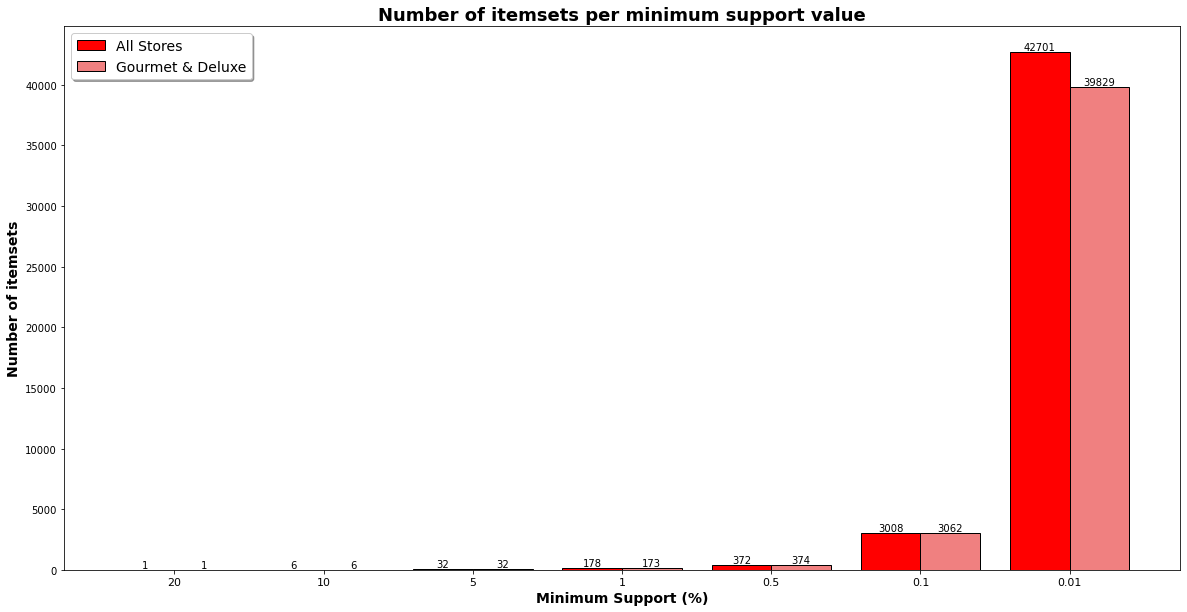

In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Prints current size
# print("Current size:", fig_size)

# Set figure width and height
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

numberItemsAllStores = [len(frequent_itemsets_20), len(frequent_itemsets_10), len(frequent_itemsets_5), len(frequent_itemsets_1), len(frequent_itemsets_05), len(frequent_itemsets_01), len(frequent_itemsets_001)]
numberItemsGourDel = [len(frequent_itemsets_DG_20), len(frequent_itemsets_DG_10), len(frequent_itemsets_DG_5), len(frequent_itemsets_DG_1), len(frequent_itemsets_DG_05), len(frequent_itemsets_DG_01), len(frequent_itemsets_DG_001)]

minSup = ['20', '10', '5', '1', '0.5', '0.1', '0.01']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["red", "lightcoral", "grey"])

def bar_group(classes, values, width=0.8):
    plt.xlabel('Minimum Support (%)', weight='semibold', size=14)
    plt.ylabel('Number of itemsets', weight='semibold', size=14)
    total_data = len(values)
    classes_num = np.arange(len(classes))
    for i in range(total_data):
        bars = plt.bar(classes_num - width / 2. + i / total_data * width, values[i], 
                width=width / total_data, align="edge", animated=0.4, edgecolor="black", linewidth=1)
        for rect in bars:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
    
    plt.title('Number of itemsets per minimum support value', size=18, weight='bold')
    plt.xticks(classes_num, classes, size=11)
    plt.legend(['All Stores', 'Gourmet & Deluxe'], shadow=True, fontsize=14)
    
bar_group(minSup, [numberItemsAllStores, numberItemsGourDel])

plt.show()

### From this first analysis, we can see that the number of itemsets formed from a given Minimum Support is almost identical, between the All Stores and the Gourmet and Deluxe Datasets.

### **Let's have a closer look at the top-10 most frequent itemsets for this type of store.**

In [42]:
from mlxtend.frequent_patterns import fpgrowth

# Compute itemsets min_support = 0.01%
frequent_itemsets_DG_001 = fpgrowth(binary_database_del_gour, min_support=0.0001, use_colnames=True)

# Add information about number of items in the itemset.
frequent_itemsets_DG_001['length'] = frequent_itemsets_DG_001['itemsets'].apply(lambda x: len(x))

# Add new column with number of occurences of the itemset in the dataset
frequent_itemsets_DG_001['#transactions'] = frequent_itemsets_DG_001['support'].apply(lambda x: x*31251)
frequent_itemsets_DG_001 = frequent_itemsets_DG_001.astype({'#transactions': 'int32'})

# Add new column with information about the percentage of transactions in which the itemset is present (more direct than looking at min_sup)
frequent_itemsets_DG_001['%transactions'] = round(frequent_itemsets_DG_001['support'].apply(lambda x: x*100), 3)

## Top-10 of Frequent 1-itemsets in Deluxe and Gourmet Supermarkets

In [43]:
#Compute the top-10 subset of itemsets with a length of 1 items. Requires a minimum support of 6.9%.
frequent_itemsets_DG_filter_1 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.069]
frequent_itemsets_DG_filter_1 = frequent_itemsets_DG_filter_1[(frequent_itemsets_DG_filter_1['length'] == 1)]

frequent_itemsets_DG_filter_1.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
21,0.069470,(Frozen Vegetables),1,2171,6.947
58,0.076126,(Canned Vegetables),1,2379,7.613
45,0.077918,(Wine),1,2435,7.792
7,0.079165,(Paper Wipes),1,2474,7.917
17,0.106173,(Cookies),1,3318,10.617
40,0.117980,(Cheese),1,3687,11.798
13,0.119388,(Dried Fruit),1,3731,11.939
1,0.121340,(Soup),1,3792,12.134
0,0.176282,(Fresh Fruit),1,5509,17.628
5,0.290071,(Fresh Vegetables),1,9065,29.007


## Top-10 of Frequent 2-itemsets in Deluxe and Gourmet Supermarkets

In [44]:
#Compute the top-10 subset of itemsets with a length of 1 items. Requires a minimum support of 2.1%.
frequent_itemsets_DG_filter_2 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.021]
frequent_itemsets_DG_filter_2 = frequent_itemsets_DG_filter_2[(frequent_itemsets_DG_filter_2['length'] == 2)]

frequent_itemsets_DG_filter_2.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
27652,0.021055,"(Fresh Vegetables, Nuts)",2,658,2.106
14456,0.021119,"(Cheese, Fresh Fruit)",2,660,2.112
21190,0.021919,"(Fresh Vegetables, Canned Vegetables)",2,685,2.192
103,0.022399,"(Soup, Fresh Fruit)",2,700,2.240
1441,0.023423,"(Paper Wipes, Fresh Vegetables)",2,732,2.342
5205,0.030015,"(Fresh Vegetables, Cookies)",2,938,3.002
14455,0.031167,"(Fresh Vegetables, Cheese)",2,974,3.117
3874,0.035679,"(Fresh Vegetables, Dried Fruit)",2,1115,3.568
104,0.036191,"(Fresh Vegetables, Soup)",2,1131,3.619
102,0.051806,"(Fresh Vegetables, Fresh Fruit)",2,1619,5.181


## Top-10 of Frequent 3-itemsets in Deluxe and Gourmet Supermarkets

In [45]:
#Compute the top-10 subset of itemsets with a length of 3 items. Requires a minimum support of 0.407%.
frequent_itemsets_DG_filter_3 = frequent_itemsets_DG_001[frequent_itemsets_DG_001['support'] >= 0.00407]
frequent_itemsets_DG_filter_3 = frequent_itemsets_DG_filter_3[(frequent_itemsets_DG_filter_3['length'] == 3)]

frequent_itemsets_DG_filter_3.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
21198,0.004096,"(Fresh Vegetables, Canned Vegetables, Fresh Fr...",3,128,0.410
27759,0.004160,"(Fresh Vegetables, Nuts, Fresh Fruit)",3,130,0.416
15836,0.004192,"(Fresh Vegetables, Wine, Fresh Fruit)",3,131,0.419
14457,0.004416,"(Fresh Vegetables, Soup, Cheese)",3,138,0.442
14462,0.004576,"(Fresh Vegetables, Cheese, Dried Fruit)",3,143,0.458
3880,0.004960,"(Fresh Vegetables, Dried Fruit, Fresh Fruit)",3,155,0.496
1445,0.005024,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3,157,0.502
14467,0.005344,"(Fresh Vegetables, Cheese, Fresh Fruit)",3,167,0.534
5229,0.006080,"(Fresh Vegetables, Cookies, Fresh Fruit)",3,190,0.608
105,0.008064,"(Fresh Vegetables, Soup, Fresh Fruit)",3,252,0.806


### When directly comparing the top 10 most frequent itemsets in the Deluxe and Gourmet stores with those of all stores, we can see, unsurprisingly, that the most bought itemsets don't really change. In this subset of stores, there is a slight increase of wine (very modest increase), as one would logically expect from a gourmet or deluxe store. 
### Besides that, the differences are very small. We should point, again, that the fact that this dataset is 45% of the whole dataset, is probably reponsible for the small differences we can observe.

#### 2.1.3. Generate Association Rules from Frequent Itemsets

### Generate association rules with a minimum confidence of C%.
- Here, we will go back to using a very low min_support, in order to be able to obtain association rules that will allow us to predict buying behaviours.
- To compensate for this, we will only choose rules with a very high confidence (we lower the initial confidence value to 0.7, in order to obtain a comparable number of association rules to that of the all stores).
- As this dataset is smaller, we will increase the minimum support level slightly, to 0.016% (corresponding to 5 transactions).

In [46]:
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

#Compute itemsets with min_support = 0.016% 
frequent_itemsets_DG_0016 = fpgrowth(binary_database_del_gour, min_support=0.00016, use_colnames=True)

# Generate association rules with confidence >= 70%
all_rules_DG_confidence_07 = association_rules(frequent_itemsets_DG_0016, metric="confidence", min_threshold=0.7)

# As certain articles, like Fresh Fruits and Fresh Vegetables, have a very high number of transactions, 
# we want to eliminate the rules that have these items as consequents. For this, we use the following filtering:
# (note that we can eliminate this, just by increasing the lift value).
all_rules_DG_confidence_07 = all_rules_DG_confidence_07[(all_rules_DG_confidence_07['consequent support'] < 0.17)]

# Sort the rules for confidence and lift values
all_rules_DG_confidence_07.sort_values(by=['confidence', 'lift'])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
341,"(Gum, Fashion Magazines)",(Dried Fruit),0.000320,0.119388,0.000224,0.7,5.863227,0.000186,2.935373
57,"(Coffee, Hard Candy, Fresh Fruit)",(Cheese),0.000320,0.117980,0.000224,0.7,5.933198,0.000186,2.940066
240,"(Paper Wipes, Tuna, Cereal)",(Cheese),0.000320,0.117980,0.000224,0.7,5.933198,0.000186,2.940066
241,"(Paper Wipes, Peanut Butter, Tuna)",(Cheese),0.000320,0.117980,0.000224,0.7,5.933198,0.000186,2.940066
374,"(Fresh Vegetables, Auto Magazines, Cereal)",(Cookies),0.000320,0.106173,0.000224,0.7,6.593038,0.000190,2.979425
...,...,...,...,...,...,...,...,...,...
287,"(Pot Scrubbers, Bagels, Fresh Fruit)",(Tuna),0.000192,0.028479,0.000192,1.0,35.113483,0.000187,inf
188,"(Milk, Soda, Ibuprofen)",(Pot Cleaners),0.000192,0.027263,0.000192,1.0,36.679577,0.000187,inf
253,"(Waffles, Candles, Wine)","(Soup, Fresh Fruit)",0.000192,0.022399,0.000192,1.0,44.644286,0.000188,inf
363,"(Hot Dogs, Cookies, Pancakes)","(Fresh Vegetables, Eggs)",0.000192,0.018879,0.000192,1.0,52.967797,0.000188,inf


### Generate association rules with a minimum lift L.

In [47]:
# Generate association rules with lift >= 10
all_rules_DG_lift = association_rules(frequent_itemsets_DG_0016, metric="lift", min_threshold=10)

# Sort the rules for lift and confidence values
all_rules_DG_lift.sort_values(by=['lift', 'confidence'])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
95,(Plastic Utensils),"(Personal Hygiene, Canned Fruit, Fresh Fruit)",0.039967,0.000480,0.000192,0.004804,10.008327,0.000173,1.004345
86,"(Personal Hygiene, Canned Fruit, Fresh Fruit)",(Plastic Utensils),0.000480,0.039967,0.000192,0.400000,10.008327,0.000173,1.600055
1067,"(Waffles, Fresh Fruit)","(Mouthwash, Canned Vegetables)",0.009984,0.001920,0.000192,0.019231,10.016346,0.000173,1.017650
1068,"(Mouthwash, Canned Vegetables)","(Waffles, Fresh Fruit)",0.001920,0.009984,0.000192,0.100000,10.016346,0.000173,1.100018
1227,(Soda),"(Fresh Vegetables, Canned Vegetables, Cold Rem...",0.052222,0.000672,0.000352,0.006740,10.030375,0.000317,1.006109
...,...,...,...,...,...,...,...,...,...
961,"(Shampoo, Gum)","(Candles, Frozen Vegetables)",0.000640,0.001696,0.000192,0.300000,176.892453,0.000191,1.426149
1467,"(Hot Dogs, Eggs)","(Fresh Vegetables, Cookies, Pancakes)",0.003296,0.000320,0.000192,0.058252,182.044660,0.000191,1.061516
1466,"(Fresh Vegetables, Cookies, Pancakes)","(Hot Dogs, Eggs)",0.000320,0.003296,0.000192,0.600000,182.044660,0.000191,2.491760
963,"(Gum, Frozen Vegetables)","(Candles, Shampoo)",0.001056,0.000512,0.000192,0.181818,355.125000,0.000191,1.221596


### Generate association rules with both confidence >= % and lift >= L.

### Here, we use the confidence and lift metrics that give us the 10 strongest association rules for this dataset.
- We use a high confidence of 0.9 and filter these rules, with a lift higher than 18.6.
- We end up with 10 rules with a support of 0.0192% (6 transactions), a confidence of 1 and high values for lift and conviction. Albeit being rare transactions, our aim, like in the previous dataset, is to identify rare rules, but that hold very high correlational metrics, to allow us to come up with rules that will revolutionize our business.

In [48]:
# Generate association rules with confidence >= 90%
all_rules_DG_confidence_1 = association_rules(frequent_itemsets_DG_0016, metric="confidence", min_threshold=0.9)

# Filter association rules using lift >= 18.6%
all_rules_DG_confidence_1_lift = all_rules_DG_confidence_1[all_rules_DG_confidence_1['lift'] >= 18.6]

# Sort the rules for confidence and lift values
all_rules_DG_confidence_1_lift.sort_values(by=['confidence', 'lift'])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
68,"(Mouthwash, Hot Dogs, Ice Cream)",(Batteries),0.000192,0.053726,0.000192,1.0,18.612865,0.000182,inf
43,"(Fresh Vegetables, Plastic Utensils, Bologna, ...",(Soda),0.000192,0.052222,0.000192,1.0,19.148897,0.000182,inf
90,"(Fresh Vegetables, Eggs, Cookies, Pancakes)",(Hot Dogs),0.000192,0.041407,0.000192,1.0,24.150696,0.000184,inf
93,"(Acetominifen, Pizza, Chips)",(Deli Salads),0.000192,0.041375,0.000192,1.0,24.169374,0.000184,inf
69,"(Hot Dogs, Ice Cream, Batteries)",(Mouthwash),0.000192,0.029023,0.000192,1.0,34.455347,0.000186,inf
70,"(Pot Scrubbers, Bagels, Fresh Fruit)",(Tuna),0.000192,0.028479,0.000192,1.0,35.113483,0.000187,inf
37,"(Milk, Soda, Ibuprofen)",(Pot Cleaners),0.000192,0.027263,0.000192,1.0,36.679577,0.000187,inf
60,"(Waffles, Candles, Wine)","(Soup, Fresh Fruit)",0.000192,0.022399,0.000192,1.0,44.644286,0.000188,inf
91,"(Hot Dogs, Cookies, Pancakes)","(Fresh Vegetables, Eggs)",0.000192,0.018879,0.000192,1.0,52.967797,0.000188,inf
59,"(Waffles, Soup, Candles)","(Wine, Fresh Fruit)",0.000192,0.014656,0.000192,1.0,68.233624,0.000189,inf


#### 2.1.4.  Deluxe/Gourmet Supermarkets versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets).

- **As we have previously mentioned, the top-10 frequent itemsets don't change between all stores and the Deluxe and Gourmet supermarkets.** 
- **When we compare the top-10 association rules obtained for the global dataset and the Deluxe + Gourmet datasets, we find that, although there are no association rules shared by the two datasets, many of the items in these rules are shared (such as "Hamburguer", "Jelly", "Rice" and "Pot Scrubers").**
- **In addition to this, we can also mention that both datasets allow to produce association rules with a high number of items both in the antecedent and in the consequent. This may be due to the high number of transactions present in both datasets: the greater the number of transactions to be considered for the same minimum support, the greater the number of larger size itemsets.**
- **The sharing of several items between the association rules of both datasets can be explained by the fact that the Deluxe + Gourmet dataset corresponds to approximately 45% of the original dataset. Thus, as the Deluxe + Gourmet dataset is the source of almost half of the transactions present in the total dataset, it is expected that the association rules as well as the frequent itemsets share some similarities. In addition, Deluxe + Gourmet presents approximately 33000 transactions, which justifies frequent large itemsets.**
- **We should highlight that, in this case, we could have looked for association rules with a higher support value, while still mantaining high confidence levels (around 0.8). We did explore this rules but settled, in the end, to maintain the same mining strategy of finding rare asssociation rules, with very high metrics. Nevertheless, we are aware of the possible caveats of this approach, as we already mentioned in the previous section.**


### 2.2. Analyse Small Groceries [For groups of 2 and 3]

Here you should analyse **Small Groceries (STORE_ID = 2, 5, 14, 22)**.

#### 2.2.1.  Load/Preprocess the Dataset

**This should be trivial now.**

In [49]:
# As we planned ahead, the dataset from small groceries is already available!!! 
# Compute binary database from small transiction matrix (transactions X products )
tr_enc = TransactionEncoder()
trans_array = tr_enc.fit(stm).transform(stm)
binary_database_small = pd.DataFrame(trans_array, columns=tr_enc.columns_)
binary_database_small

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2274,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2275,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2276,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


#### According to the Small Groceries store transaction database, we were able to highlight a big difference regarding the number of transactions in the global dataset and the Deluxe + Gormet dataset.
#### Small Groceries transaction database include a total of 2278 transactions, roughly 3.3% of the global dataset. This small percentage of transactions may be reflected in large differences in the itemsets that are identified as frequent itemsets and, thus, contrast with our observations in the Deluxe + Gormet frequent itemsets.

#### 2.2.2. Compute Frequent Itemsets

#### We will start by comparing the number of frequent itemsets we obtain for different minimum support values, for the three different datasets we analysed.

In [50]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets_Small_001 = fpgrowth(binary_database_small, min_support=0.0001, use_colnames=True)

numberItemsSmall = []
minSup = [0.20, 0.10, 0.05, 0.01, 0.005, 0.001, 0.0001]

for i in minSup:
    NumItemSmall = frequent_itemsets_Small_001[frequent_itemsets_Small_001['support'] >= i]
    numberItemsSmall.append(len(NumItemSmall))

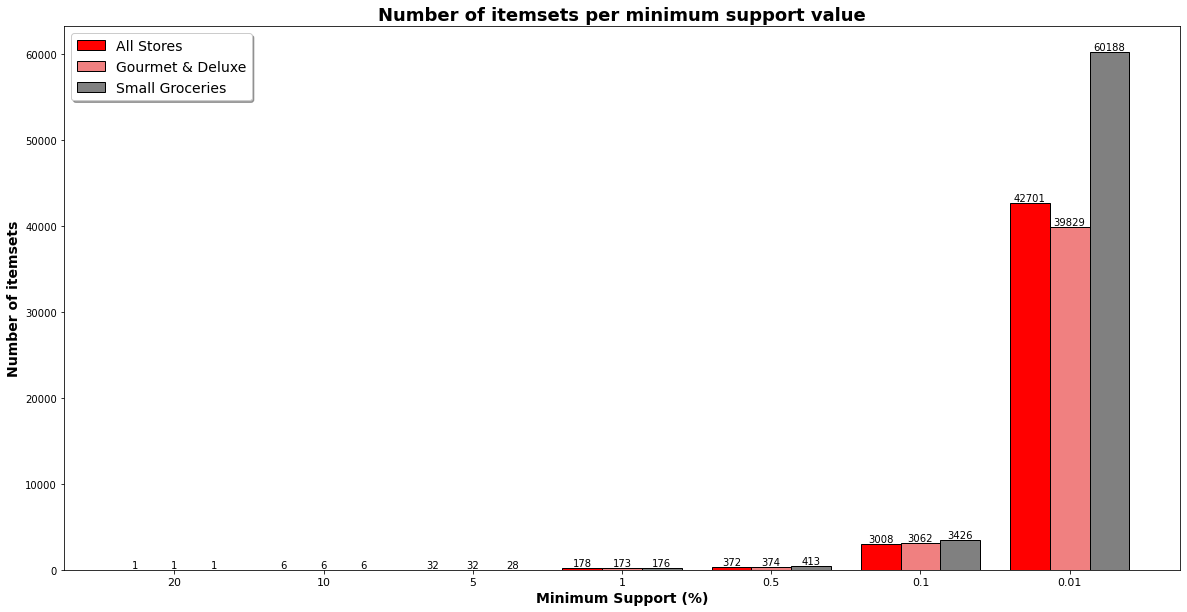

In [51]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Prints current size
# print("Current size:", fig_size)

# Set figure width and height
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

numberItemsAllStores = [len(frequent_itemsets_20), len(frequent_itemsets_10), len(frequent_itemsets_5), len(frequent_itemsets_1), len(frequent_itemsets_05), len(frequent_itemsets_01), len(frequent_itemsets_001)]
numberItemsGourDel = [len(frequent_itemsets_DG_20), len(frequent_itemsets_DG_10), len(frequent_itemsets_DG_5), len(frequent_itemsets_DG_1), len(frequent_itemsets_DG_05), len(frequent_itemsets_DG_01), len(frequent_itemsets_DG_001)]

minSup = ['20', '10', '5', '1', '0.5', '0.1', '0.01']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["red", "lightcoral", "grey"])

def bar_group(classes, values, width=0.8):
    plt.xlabel('Minimum Support (%)', weight='semibold', size=14)
    plt.ylabel('Number of itemsets', weight='semibold', size=14)
    total_data = len(values)
    classes_num = np.arange(len(classes))
    for i in range(total_data):
        bars = plt.bar(classes_num - width / 2. + i / total_data * width, values[i], 
                width=width / total_data, align="edge", animated=0.4, edgecolor="black", linewidth=1)
        for rect in bars:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
    
    plt.title('Number of itemsets per minimum support value', size=18, weight='bold')
    plt.xticks(classes_num, classes, size=11)
    plt.legend(['All Stores', 'Gourmet & Deluxe', 'Small Groceries'], shadow=True, fontsize=14)
    
bar_group(minSup, [numberItemsAllStores, numberItemsGourDel, numberItemsSmall])

plt.show()

**From the analysis of this dataset, we can observe:**

> - The number of frequent itemsets obtained for each minimum support value are actually comparable to both previous datasets;
> - There is a high number of frequent itemsets when we consider the small groceries dataset with a minimum support of 0.01%.
> - In this dataset, a minimum support of 0.01% size allows the algorithm to identify patterns that are represented in a single transaction. Thus, the high value of frequent itemsets for this set of transactions corresponds to all possible combinations of items that are present and, therefore, does not identify any informative pattern.**

### **Let's have a closer look at the top-10 most frequent itemsets for this type of store.**

In [52]:
from mlxtend.frequent_patterns import fpgrowth

# Compute itemsets min_support = 0.3%
frequent_itemsets_S_03 = fpgrowth(binary_database_small, min_support=0.003, use_colnames=True)

# Add information about number of items in the itemset.
frequent_itemsets_S_03['length'] = frequent_itemsets_S_03['itemsets'].apply(lambda x: len(x))

# Add new column with number of occurences of the itemset in the dataset
frequent_itemsets_S_03['#transactions'] = frequent_itemsets_S_03['support'].apply(lambda x: x*2278)
frequent_itemsets_S_03 = frequent_itemsets_S_03.astype({'#transactions': 'int32'})

# Add new column with information about the percentage of transactions in which the itemset is present (more direct than looking at min_sup)
frequent_itemsets_S_03['%transactions'] = round(frequent_itemsets_S_03['support'].apply(lambda x: x*100), 2)

## Top-10 of Frequent 1-itemsets in Small Groceries

In [53]:
#Compute the top-10 subset of itemsets with a length of 1 items. Requires a minimum support of 6.9%.
frequent_itemsets_S_filter_1 = frequent_itemsets_S_03[frequent_itemsets_S_03['support'] >= 0.068]
frequent_itemsets_S_filter_1 = frequent_itemsets_S_filter_1[(frequent_itemsets_S_filter_1['length'] == 1)]

frequent_itemsets_S_filter_1.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
35,0.072432,(Chocolate Candy),1,165,7.24
33,0.078139,(Paper Wipes),1,178,7.81
40,0.082090,(Canned Vegetables),1,187,8.21
72,0.088674,(Wine),1,202,8.87
9,0.107550,(Cookies),1,245,10.76
32,0.107989,(Dried Fruit),1,246,10.80
0,0.119842,(Soup),1,273,11.98
5,0.119842,(Cheese),1,273,11.98
29,0.178665,(Fresh Fruit),1,407,17.87
2,0.286655,(Fresh Vegetables),1,653,28.67


## Top-10 of Frequent 2-itemsets in Small Groceries

In [54]:
#Compute the top-10 subset of itemsets with a length of 2 items. Requires a minimum support of 2.2%.
frequent_itemsets_S_filter_2 = frequent_itemsets_S_03[frequent_itemsets_S_03['support'] >= 0.022]
frequent_itemsets_S_filter_2 = frequent_itemsets_S_filter_2[(frequent_itemsets_S_filter_2['length'] == 2)]

frequent_itemsets_S_filter_2.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
509,0.022827,"(Fresh Vegetables, Chocolate Candy)",2,52,2.28
837,0.022827,"(Fresh Vegetables, Nuts)",2,52,2.28
876,0.023266,"(Fresh Vegetables, Wine)",2,52,2.33
488,0.023705,"(Dried Fruit, Fresh Fruit)",2,54,2.37
494,0.023705,"(Paper Wipes, Fresh Vegetables)",2,54,2.37
584,0.024583,"(Fresh Vegetables, Canned Vegetables)",2,56,2.46
192,0.025900,"(Fresh Vegetables, Cookies)",2,59,2.59
157,0.035119,"(Fresh Vegetables, Cheese)",2,80,3.51
486,0.035119,"(Fresh Vegetables, Dried Fruit)",2,80,3.51
102,0.038630,"(Fresh Vegetables, Soup)",2,88,3.86


## Top-10 of Frequent 3-itemsets in Small Groceries

In [55]:
#Compute the top-10 subset of itemsets with a length of 3 items. Requires a minimum support of 0.048%.
frequent_itemsets_S_filter_3 = frequent_itemsets_S_03[frequent_itemsets_S_03['support'] >= 0.0048]
frequent_itemsets_S_filter_3 = frequent_itemsets_S_filter_3[(frequent_itemsets_S_filter_3['length'] == 3)]

frequent_itemsets_S_filter_3.sort_values(by=['support'])

,support,itemsets,length,#transactions,%transactions
159,0.004829,"(Fresh Vegetables, Cheese, Fresh Fruit)",3,11,0.48
518,0.004829,"(Fresh Vegetables, Canned Vegetables, Chocolat...",3,11,0.48
583,0.004829,"(Fresh Vegetables, Soda, Dried Fruit)",3,11,0.48
881,0.004829,"(Fresh Vegetables, Wine, Fresh Fruit)",3,11,0.48
517,0.005268,"(Paper Wipes, Fresh Vegetables, Chocolate Candy)",3,12,0.53
198,0.005707,"(Fresh Vegetables, Soup, Cookies)",3,13,0.57
104,0.006146,"(Fresh Vegetables, Soup, Fresh Fruit)",3,14,0.61
158,0.006146,"(Fresh Vegetables, Soup, Cheese)",3,14,0.61
492,0.006146,"(Fresh Vegetables, Cheese, Dried Fruit)",3,14,0.61
197,0.006585,"(Fresh Vegetables, Cookies, Fresh Fruit)",3,15,0.66


- **Considering that the small groceries dataset has a total of 2278 transactions, corresponding to approximately 3.3% of the original dataset, it would be expected that the minimum support value to be used for this subset of transactions would be higher when compared to the minimum support value defined for deluxe and gormet stores or even with the full dataset.**

- **Interestingly, the minimum support values used to identify the top 10 of size 1, 2 and 3 of frequent itemsets are roughly the same in the 3 cases (when considering the all dataset, just Deluxe + Gourmet or just the Small groceries dataset).**

#### 2.2.3. Generate Association Rules from Frequent Itemsets

- For the generation of association rules for the small groceries, we will go straing to listing the top association rules (applying similar filtering as the one in the previous sections of this work).
- Here, we are using a low min_support, in order to be able to obtain association rules that will allow us to predict buying behaviours in small grocery stores.
- To compensate for this, we will only choose rules with a very high confidence.
- As this dataset is much smaller than previous ones, we will increase the minimum support level to 0.1% (corresponding to roughly 3 transactions).
- We will finally filter the rules, by selecting a lift above 15, to end up with the strongest rules given by our parameters.

In [56]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

#Compute itemsets with min_support = 0.1% 
frequent_itemsets_S_01 = fpgrowth(binary_database_small, min_support=0.001, use_colnames=True)

# Generate association rules with confidence >= 90%
all_rules_confidence_S = association_rules(frequent_itemsets_S_01, metric="confidence", min_threshold=0.9)

# Filter rules, for lift values > 15
all_rules_confidence_S = all_rules_confidence_S[all_rules_confidence_S['lift'] > 15]

# Sort the rules for confidence and lift values
all_rules_confidence_S.sort_values(by=['confidence', 'lift'])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
39,"(Dried Fruit, Anchovies)",(Dips),0.001317,0.056190,0.001317,1.0,17.796875,0.001243,inf
25,"(Fresh Vegetables, Mouthwash, Spices)",(Cereal),0.001317,0.055751,0.001317,1.0,17.937008,0.001244,inf
7,"(Soup, Preserves, Cheese)",(Personal Hygiene),0.001317,0.052239,0.001317,1.0,19.142857,0.001248,inf
21,"(Wine, Nuts, Cheese)",(Coffee),0.001317,0.048727,0.001317,1.0,20.522523,0.001253,inf
29,"(Candles, Wine)",(Hot Dogs),0.001317,0.048288,0.001317,1.0,20.709091,0.001253,inf
35,"(Coffee, Sunglasses)",(Hot Dogs),0.001317,0.048288,0.001317,1.0,20.709091,0.001253,inf
10,"(Deli Meats, Jam)",(Bologna),0.001317,0.043459,0.001317,1.0,23.010101,0.001260,inf
38,"(Yogurt, Canned Vegetables)",(Aspirin),0.001317,0.024583,0.001317,1.0,40.678571,0.001285,inf
42,"(Pancake Mix, Canned Fruit)",(Beer),0.001317,0.022388,0.001317,1.0,44.666667,0.001287,inf


- **Once more, our strategy allowed us to obtained low frequent but strong association rules, with high values of confidence and lift. With the Small Groceries dataset, we identified the above mentioned rules wich we belive translates into solid buying patterns.**
- **From an analyst's point of view, the items identified in the association rules correspond mostly to items that are used daily and, therefore, there is some sense in their purchase in Small Groceries stores.**
- **We explored uncountable metrics, trying to strike a balance between the low minimum support value, and the confidence and lift values. Although there were some results where the confidence and lift values were compromised but still indicated good quality rules, we decided to keep the same search strategy for strong rules with low occurrence (rare rules) but with high confidence and lift values.**

### 2.2.4 Small Groceries versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only Small Groceries).

- **According to the frequent itemsets defined from the total dataset, it is observed that the differences between the frequent itemsets of size 1 obtained in Small Groceries and the frequent itemsets obtained for all stores are small. We can see that "Chocolate candy" is a frequently bought item in Small Groceries but is not present in the top 10 frequent itemsets in all stores. In contrast, "Frozen vegetables" is not present in the top 10 of frequent itemsets in Small Groceries, but it is present when analyzing all dataset. From a logical point of view, this makes total sense, given that "Chocolate candy" is typicaly acquired in small groceries stores and "Frozen vegetables" are normaly bought in Supermarkets or other larger stores.**

- **Regarding the association rules obtained for Small Groceries, they present great differences when compared with the association rules obtained for the total dataset. This analysis makes it obvious that the association rules obtained from the total dataset would lead to weak rules (or no rules) for the small grocery stores. Thus, it will be favorable to apply marketing strategies that take into account the type of store and, therefore, the association rules obtained for each type of store in detriment of the association rules obtained for the total dataset.**

- **For instance, one of the association rules drawn from the global dataset identifies a relationship from the purchase of (Cleaners, Pot scrubers, Jelly, Rice) -> (Hamburguer) but when considering the association rules drawn from the Small Groceries dataset we confirm that non of this products are present in association rules nor even in frequent itemsets.**

- **We believe that there might be appropriate algorithms and strategies to identify common rules between different dataset (and sets of association rules derived from them). Unfortunately, we were not yet introduced to this type of advanced techniques for data mining and pattern analysis.**

### 2.3.  Deluxe/Gourmet Supermarkets versus Small Groceries  [For groups of 2 and 3]

Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets) and those obtained in task 2.2. (frequent itemsets and association rules found in transactions only Small Groceries).

- **Similarly to the previous datasets, we can observe no shared association rules between the Deluxe + Gourmet dataset and the Small Groceries dataset (when considering the shortlist of top association rules we defined).**

- **The type of products obtained in the association rules are completely different from one another. From a logical point of view, the rules obtained for Small Groceries include items that tend to be purchased in this type of (convenience) stores. In addition, these association rules correspond to small itemsets. This can probably be related to the small number of transactions to be taken into account. When considering a low number of transactions, the size of itemsets identified as frequent tends to be smaller. This results in association rules with two or three products in the background and one product as a consequence.** 

- **Moreover, it should be noted that the amount of items bought in small grocery shops is normally much smaller than those bought in supermarkets. Out of the 2278 transactions in the small grocery stores, only 52 transactions had 3 items. No transactions with more than 3 items were observed.**

- **Regarding the association rules obtained for Deluxe + Gourmet, they feature longer itemsets and include products that would not normally be purchased at Small Groceries stores (such as "Oysters", "Pot cleaners", "Cleaners" and other products normally bought at larger supermarkets).**

- **Even so, the association rules present in both cases share some convenience items (such as "Coffe" and "Cereal").**



### Final Conclusions

Data mining is a complex process to understand data and help take decisions. Pattern mining, the focus of this project, aims at identifying interesting, useful and unexpected patterns from (large) datasets. In this work, we have analyzed the Foodmart_2020_PD dataset. This dataset contains 69549 transactions taken from 24 stores, where 102 different products can be bought. The 24 stores are distributed across Gourmet supermarkets, Deluxe Supermarkets, Mid-Size grocery stores, Small grocery stores and supermarkets. Besides analysing the transactions for all stores, we also analyzed a subset of transactions from Gourmet and Deluxe supermarkets and from Small Grocery stores. 

We first identified the most sold items in these different datasets. This showed us that, despite small differences, the most bought items are similar across store types. In addition, by using low minimum support values together with high values for confidence and lift, we focused on discovering rare, but strong, association rules. Some of the association rules we found are logical, some unexpected. These rules will allow us to propose business strategies to try and boost the sale of certain antecendents in itemsets, with the aim of increasing the sale of consequents. These measures can contemplate promotions on certain types of products, product placement (placing the highest profit margin consequent, close to its antecedents) or even sell products in packs. 

With the analysis we made, it is clear that the list of strongest rules we found is not shared between different datasets. In fact, we could not find an universal rule for all store types. For this reason, the set of rules we found should be applied to the specific subset of stores for which rules were determined: Deluxe and Gourmet supermakets and Small Grocery stores. In the future, using algorithms and tools to analyze sets of rules and find common patterns in between the different store types will allow to identify common buying patterns from buyers associated with different types of stores. Ultimately, this would allow us start designing additional business strategies aimed simultaneously at all the different type of stores.

Finally, it should be noted that the strategy we choose in this work has some potential drawbacks. First and foremost, we are focusing in transactions that happened rarely and might not hold true when put into a scenario of increased transaction number. Second, the metrics we choose are rather drastic (confidence of 100% and lift around 10 to 35) and might lead to the loss of other strong and interesting rules. Whereas we are aware of these caveats in our analysis, our choice of pursuing rare association rules with metrics suggesting that these hold true all the time is, undoubtedly a bet that may pay very high rewards.

In summary, the work presented here is a fine example of how unscrupulous business men can make clients buy products that they do not even know they need!